In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

# Few helpful definitions

- **Prior** probability is a distribution over the parameters of data distribution $\mathbb{P}(\theta)$
- **Likelihood** is the probability model of data we are considering $\mathbb{P}(X | \theta)$
- **Posterior** probability is a distribution over the parameter of a distribution given data provided
  $\mathbb{P}(\theta | X) $

 **Inference** is done using a simple Bayes rule:
$$
\mathbb{P}(\theta | X) = \frac{\mathbb{P}(X | \theta) \mathbb{P}(\theta)}{
\int_{\Theta} \mathbb{P}(X|\vartheta) \mathbb{P}(\vartheta) d\vartheta
}
$$

In [3]:
# In the meantime I'll define thin wrappers around the probability distributions
class Bernoulli:
    def __init__(self, p):
        self.p = p
    
    def sample(self, size=1):
        return stats.bernoulli.rvs(p=self.p, size=size)
        
class Uniform:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def sample(self, size=1):
        return stats.uniform.rvs(loc=self.start, scale=self.end-self.start, size=size)
    
    def pdf(self, x):
        return stats.uniform.pdf(x, loc=self.start, scale=self.end-self.start)
    
    def mean(self):
        return stats.uniform.mean(loc=self.start, scale=self.end-self.start)
        
class Beta:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def pdf(self, X):
        return stats.beta.pdf(X, a=self.alpha, b=self.beta)
    
    def mean(self):
        return stats.beta.mean(a=self.alpha, b=self.beta)
    
    
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, X):
        return stats.norm.pdf(X, loc=self.mu, scale=self.sigma)
    
    def sample(self, size=1):
        return stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size)
    
    def mean(self):
        return self.mu

# Concrete example - discrete case
Let's consider a simple example, where:
- Prior $\mathbb{P}(\theta) \sim U(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim B(\theta)$

In [4]:
N = 100

In [5]:
Prior = Uniform(0, 1)

In [6]:
hidden_theta = Prior.sample()[0]
hidden_theta

0.6551248754806633

In [44]:
Likelihood = Bernoulli(hidden_theta)

In [45]:
X = Likelihood.sample(size=N)

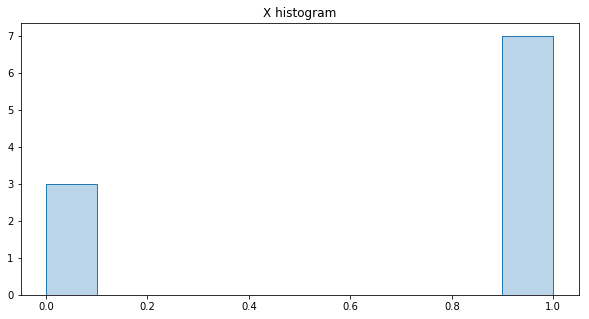

In [46]:
fig, axs = plt.subplots(1, 1)
axs.set_title("X histogram")
color = next(axs._get_lines.prop_cycler)["color"]
axs.hist(X, density=True, color=color, alpha=0.3)
axs.hist(X, density=True, color=color, edgecolor=color, fc="None", lw=1)

None

If we evaluate, the posterior pdf analytically, we can see that it is a **beta** distribution, which turns out to be a **conjugage prior** of the bernoulli distribution.

If we define two helper variables for this problem
- Number of successes $s = \sum_i x_i$
- Number of failures $p = \sum_i (1-x_i)$

Then the posterior pdf can be written as:

$$
\mathbb{P}(\theta | X) = 
\frac{ \prod_i \theta^x_i (1 - \theta)^{1 - x_i}}{ 
\int_\Theta  
\prod_i \vartheta^x_i (1 - \vartheta)^{1 - x_i} d\vartheta
}
=
\frac{ \theta^s (1-\theta)^p}{ 
\int_\Theta  
\prod_i \vartheta^s (1-\vartheta)^p d\vartheta
}
=
\frac{ \theta^s (1-\theta)^p}{  
\textrm{Beta}(s + 1, p + 1)
}
\sim
\textrm{Beta}(s + 1, p + 1)
$$

In [10]:
Posterior = Beta(X.sum() + 1, (1-X).sum() + 1)

In [11]:
successes = X.sum()
failures = (1-X).sum()

In [12]:
hidden_theta

0.6551248754806633

In [13]:
mle = successes / (successes + failures)  # In other words, mode of a distribution

In [14]:
mle

0.61

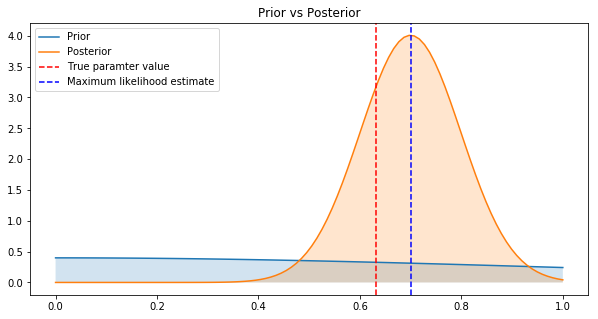

In [30]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(0.0, 1.0, 100)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, Posterior.pdf(support), label="Posterior")
axs.fill_between(support, 0, Posterior.pdf(support), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label="True paramter value")
axs.axvline(mle, color='blue', linestyle='--', label="Maximum likelihood estimate")

axs.legend()
None

# Second example - continuous case

- Prior $\mathbb{P}(\theta) \sim N(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim N(\theta, 1)$

In [16]:
N = 100

In [17]:
Prior = Normal(0, 1)

In [18]:
hidden_theta = Prior.sample()[0]

In [19]:
hidden_theta

0.6308276425254711

In [50]:
Likelihood = Normal(hidden_theta, 1)

In [51]:
X = Likelihood.sample(N)

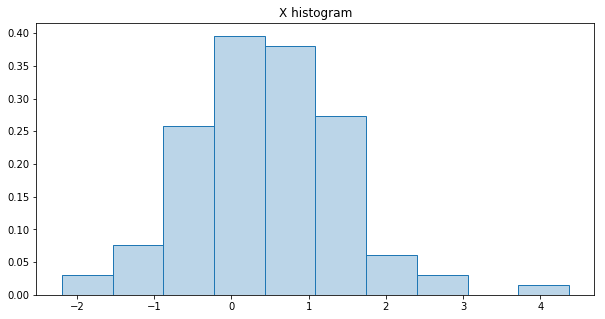

In [52]:
fig, axs = plt.subplots(1, 1)
axs.set_title("X histogram")
color = next(axs._get_lines.prop_cycler)["color"]
axs.hist(X, density=True, color=color, alpha=0.3)
axs.hist(X, density=True, color=color, edgecolor=color, fc="None", lw=1)
None

After doing some algebra, we can find that the posterior distribution is a normal distribution with parameters:
- $\mu = \frac{\sum_i x_i}{n+1}$
- $\sigma = \frac{1}{\sqrt{n+1}}$

In [23]:
Posterior = Normal(X.sum() / (X.size + 1), 1.0 / np.sqrt(X.size + 1))

In [24]:
hidden_theta

0.6308276425254711

In [25]:
mle = Posterior.mean()

In [26]:
mle

0.6996963976960487

In terms of normal distribution, MLE is equal to the mean of the parameter.

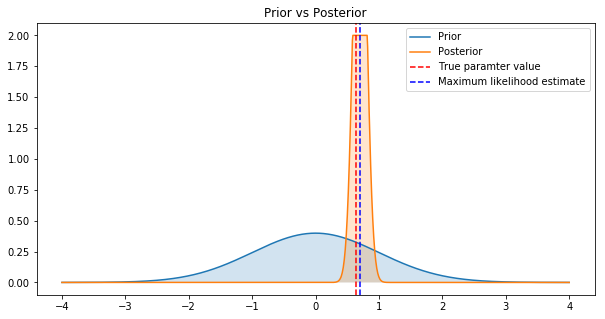

In [53]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(-4, 4, 10_00)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, np.minimum(Posterior.pdf(support), 2.0), label="Posterior")
axs.fill_between(support, 0, np.minimum(Posterior.pdf(support), 2.0), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label="True paramter value")
axs.axvline(mle, color='blue', linestyle='--', label="Maximum likelihood estimate")


axs.legend()